In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [ ]:
#reshaping the array(preprocessing)
x_train = x_train.reshape(x_train.shape[0], -1) / 255.
x_test = x_test.reshape(x_test.shape[0], -1) / 255.
print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


In [ ]:
#initializing rbm model
rbm = BernoulliRBM(n_components=256, learning_rate=0.01, n_iter=10, random_state=42)

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
#scaling the features


In [ ]:
#function to plot original and reconstructed images
def plot_original_and_reconstructed(original, reconstructed, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Reconstructed images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')
    plt.show()

In [ ]:
rbm.fit(x_train_scaled)

BernoulliRBM(learning_rate=0.01, random_state=42)

In [ ]:
#extracing latent features
x_train_latent = rbm.transform(x_train_scaled)
x_test_latent = rbm.transform(x_test_scaled)

print(x_train_latent.shape, x_test_latent.shape)

(60000, 256) (10000, 256)


In [ ]:
# function to reconstruct the input from the hidden representation
def reconstruct_rbm(rbm, hidden_representation):
    return np.dot(hidden_representation, rbm.components_) + rbm.intercept_visible_


In [ ]:
# reconstructing the  data
x_train_reconstructed = reconstruct_rbm(rbm, x_train_latent)
x_test_reconstructed = reconstruct_rbm(rbm, x_test_latent)

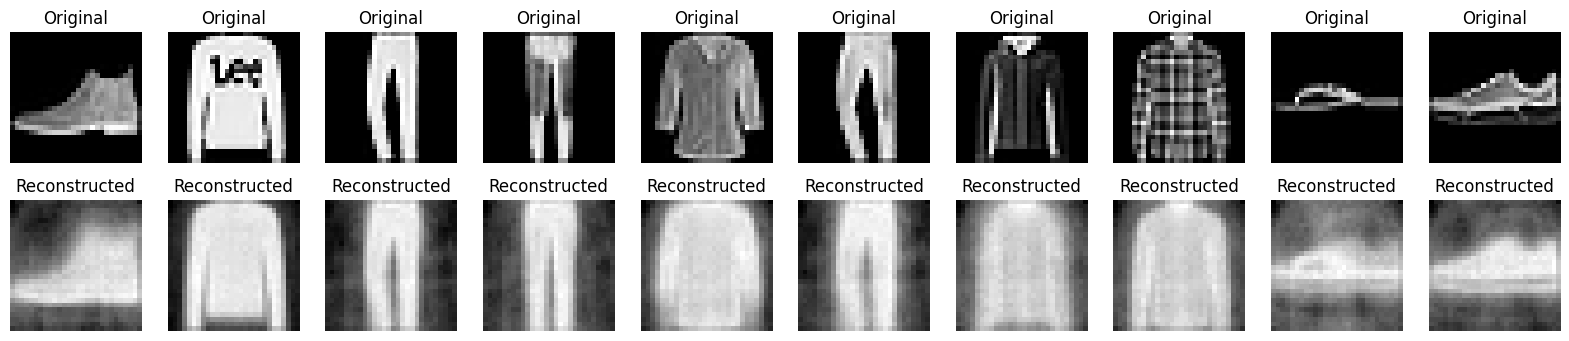

In [ ]:
plot_original_and_reconstructed(x_test_scaled, x_test_reconstructed)

In [ ]:
#creating the model layers
input_layer = Input(shape=(x_train_latent.shape[1],))
hidden_layer_1 = Dense(128, activation='relu')(input_layer)
hidden_layer_2 = Dense(64, activation='relu')(hidden_layer_1)
output_layer = Dense(10, activation='softmax')(hidden_layer_2)

In [ ]:
#creating the mlp model which uses the rbm latent layer
mlp_model = Model(inputs=input_layer, outputs=output_layer)
mlp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
mlp_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256)]             0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 41802 (163.29 KB)
Trainable params: 41802 (163.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
mlp_model.fit(x_train_latent, y_train, epochs=20, batch_size=128, validation_data=(x_test_latent, y_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 2s 27us/sample - loss: 0.5659 - acc: 0.7969 - val_loss: 0.4737 - val_acc: 0.8249
Epoch 2/20
 2688/60000 [>.............................] - ETA: 1s - loss: 0.4334 - acc: 0.8315

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


60000/60000 [==============================] - 1s 24us/sample - loss: 0.4229 - acc: 0.8421 - val_loss: 0.4259 - val_acc: 0.8400
Epoch 3/20
60000/60000 [==============================] - 1s 23us/sample - loss: 0.4021 - acc: 0.8502 - val_loss: 0.4196 - val_acc: 0.8418
Epoch 4/20
60000/60000 [==============================] - 1s 24us/sample - loss: 0.3841 - acc: 0.8557 - val_loss: 0.4134 - val_acc: 0.8464
Epoch 5/20
60000/60000 [==============================] - 2s 36us/sample - loss: 0.3732 - acc: 0.8589 - val_loss: 0.4044 - val_acc: 0.8497
Epoch 6/20
60000/60000 [==============================] - 2s 36us/sample - loss: 0.3656 - acc: 0.8626 - val_loss: 0.3972 - val_acc: 0.8543
Epoch 7/20
60000/60000 [==============================] - 1s 24us/sample - loss: 0.3585 - acc: 0.8658 - val_loss: 0.3851 - val_acc: 0.8556
Epoch 8/20
60000/60000 [==============================] - 1s 23us/sample - loss: 0.3508 - acc: 0.8682 - val_loss: 0.3970 - val_acc: 0.8522
Epoch 9/20
60000/60000 [==============

In [ ]:
loss_latent, accuracy_latent = mlp_model.evaluate(x_test_latent, y_test)
print(f'Test accuracy using RBM latent representations: {accuracy_latent}')

Test accuracy using RBM latent representations: 0.8686000108718872


In [ ]:
input_layer_raw = Input(shape=(x_train.shape[1],))
hidden_layer_1_raw = Dense(128, activation='relu')(input_layer_raw)
hidden_layer_2_raw = Dense(64, activation='relu')(hidden_layer_1_raw)
output_layer_raw = Dense(10, activation='softmax')(hidden_layer_2_raw)


In [ ]:
#mlp layer which uses the raw images
mlp_model_raw = Model(inputs=input_layer_raw, outputs=output_layer_raw)
mlp_model_raw.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

mlp_model_raw.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_3 (Dense)             (None, 128)               100480    
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 109386 (427.29 KB)
Trainable params: 109386 (427.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
mlp_model_raw.fit(x_train, y_train, epochs=20, batch_size=128, validation_data=(x_test, y_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 4s 65us/sample - loss: 0.5534 - acc: 0.8086 - val_loss: 0.4502 - val_acc: 0.8416
Epoch 2/20
60000/60000 [==============================] - 2s 32us/sample - loss: 0.3915 - acc: 0.8609 - val_loss: 0.4140 - val_acc: 0.8517
Epoch 3/20
60000/60000 [==============================] - 2s 33us/sample - loss: 0.3524 - acc: 0.8728 - val_loss: 0.3668 - val_acc: 0.8692
Epoch 4/20
60000/60000 [==============================] - 3s 53us/sample - loss: 0.3227 - acc: 0.8827 - val_loss: 0.3546 - val_acc: 0.8752
Epoch 5/20
60000/60000 [==============================] - 3s 43us/sample - loss: 0.3070 - acc: 0.8884 - val_loss: 0.3527 - val_acc: 0.8701
Epoch 6/20
60000/60000 [==============================] - 2s 33us/sample - loss: 0.2913 - acc: 0.8919 - val_loss: 0.3440 - val_acc: 0.8755
Epoch 7/20
60000/60000 [==============================] - 2s 33us/sample - loss: 0.2773 - acc: 0.8974 - val_loss: 0.

In [ ]:
loss_raw, accuracy_raw = mlp_model_raw.evaluate(x_test, y_test)
print(f'Test accuracy using raw images: {accuracy_raw}')


Test accuracy using raw images: 0.8808000087738037


In [ ]:
results = {
    'Model': ['mlp with latent representations', 'mlp with raw images'],
    'Loss': [loss_latent, loss_raw],
    'Accuracy': [accuracy_latent, accuracy_raw]
}
df_results = pd.DataFrame(results)
print(df_results)


                             Model      Loss  Accuracy
0  mlp with latent representations  0.363005    0.8686
1              mlp with raw images  0.361490    0.8808
